In [2]:
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import json
import math
import EoN
import seaborn as sns
import time

# New Imports
#from ctrace.contact_tracing import *
#from ctrace.constraint import *
#from ctrace.solve import *
#from ctrace.simulation import *
#from ctrace.restricted import *
from ctrace.simulation import *
from ctrace.dataset import *
from ctrace.recommender import *
from ctrace.problem import *

In [11]:
ann = [NoIntervention, Random, EC, DegGreedy_fair, DepRound_fair]

I_arr = []

for agent in [NoIntervention, Random, EC, DegGreedy_fair, DepRound_fair]:

    with open("../data/SIR_Cache/c7.json", 'r') as infile:
        j = json.load(infile)

        (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
        infections = j["infections"]

    G = load_graph_montgomery_labels()
    G.centrality = nx.algorithms.eigenvector_centrality_numpy(G)

    state = InfectionState(G, (S, I1, I2, R), 1000, "none", 0.05, False, 0.8, False, 1, 1)

    while len(state.SIR.I1) + len(state.SIR.I2) != 0:
        to_quarantine = agent(state)
        state.step(to_quarantine)
        infections.append(len(state.SIR.I2))

    I_arr.append(infections)
    #plt.scatter(x = [i for i in range(len(infections))], y = infections)
#plt.show()
#plt.legend(ann)

In [14]:
size = 0
for i in I_arr:
    size = max(size, len(i))
    
for i in range(len(I_arr)):
    while(len(I_arr[i]) < size):
        I_arr[i].append(0)

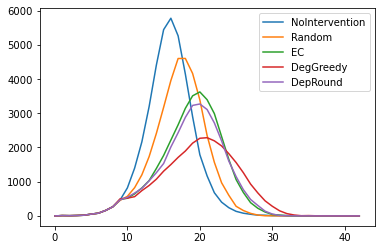

In [19]:
sns.lineplot(x=[i for i in range(size)], y = I_arr[0])
sns.lineplot(x=[i for i in range(size)], y = I_arr[1])
sns.lineplot(x=[i for i in range(size)], y = I_arr[2])
sns.lineplot(x=[i for i in range(size)], y = I_arr[3])
sns.lineplot(x=[i for i in range(size)], y = I_arr[4])
ann = ["NoIntervention", "Random", "EC", "DegGreedy", "DepRound"]

plt.legend(ann)

In [2]:
with open("../data/SIR_Cache/c7.json", 'r') as infile:
    j = json.load(infile)

    (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
    infections = j["infections"]

l = 0
r = 20000 

iters = 0

while l <= r:
    m = l + (r-l)//2

    average = 0
    
    iters += 1
    print("begin", iters, m)
    for i in range(1):
        G = load_graph_montgomery_labels()

        state = InfectionState(G, (S, I1, I2, R), m, "none", 0.05, False, 0.8, False, 1, 1)

        while len(state.SIR.I1) + len(state.SIR.I2) != 0:
            to_quarantine = DegGreedy2_fair(state)
            state.step(to_quarantine)

        average += len(state.SIR.R)
        
    print(average)
    if average >= 35000:
        l = m+1
    else: 
        r = m-1
        
print(m)

begin 1 10000
13302
begin 2 4999
13316
begin 3 2499
14744
begin 4 1249
28342
begin 5 624
35690
begin 6 936
32706
begin 7 780
34661
begin 8 702
35011
begin 9 741
34608
begin 10 721
34988
begin 11 711
35398
begin 12 716
34768
begin 13 713
34791
begin 14 712
35432
712


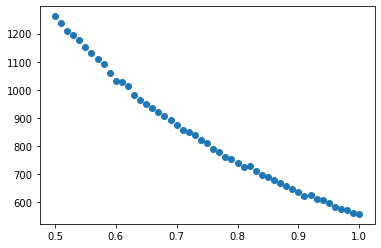

In [4]:
df = pd.read_csv("../output/run_KRmS4/results.csv")

plt.scatter(df['compliance_rate'], df['equivalent_budget'])

In [9]:
df = pd.read_csv("../output/run_JtDPZ/results.csv")

df = df[df.agent == "DepRound2_fair"]

print(df['infection_count'].mean())

df = pd.read_csv("../output/run_JtDPZ/results.csv")

df = df[df.agent == "DegGreedy2_fair"]

print(df['infection_count'].mean())


33909.55
32094.25


In [12]:
a = [1,2,3,4,5,6,7,8,9]

l = 0
r = 8

while l <= r:
    
    m = (r+l)//2
    print(m)
    
    if a[m] > 7:
        r = m-1
    elif a[m] < 7:
        l = m+1
    else:
        print("YAY", m)
        break
        
print(l,r,(l+r)//2)

4
6
YAY 6
5 8 6


In [2]:
# run_EJv4i - vary discovery montgomery

In [3]:
# - vary snitch montgomery

<AxesSubplot:xlabel='budget', ylabel='infection_count'>

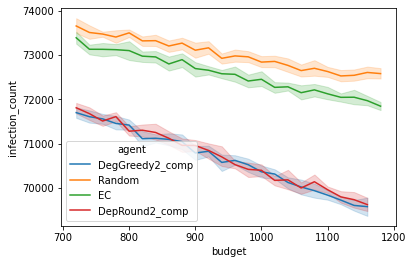

In [6]:
df = pd.read_csv("../output/run_mdioi/results.csv")

sns.lineplot(data=df,x='budget',y='infection_count',hue='agent')

<AxesSubplot:xlabel='budget', ylabel='infection_count'>

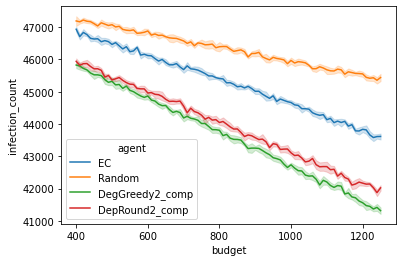

In [5]:
df = pd.read_csv("../output/run_B7UWt/results.csv")

sns.lineplot(data=df,x='budget',y='infection_count',hue='agent')

In [11]:
G = load_graph_montgomery()

In [27]:
G.centrality = nx.algorithms.eigenvector_centrality_numpy(state.G)

In [13]:
centrality = nx.algorithms.eigenvector_centrality_numpy(G)

In [24]:
def EC(state: InfectionState):
    
    eigens: List[Tuple[int, int]] = []

    for u in state.V1:
        eigens.append((state.G.centrality[u], u))
    
    eigens.sort(reverse=True)
    return {i[1] for i in eigens[:state.budget]}


In [25]:
from ctrace.utils import *

G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "c7.json", 'r') as infile:
            j = json.load(infile)
            (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
            infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 1000, "none", 0.05, 0.8, True)

In [28]:
while len(state.SIR.I1 )+ len(state.SIR.I2)!=0:
    state.step(EC(state))
    print(len(state.SIR.R))

341
610
1080
1652
2434
3505
4988
7031
9838
13249
17207
21429
25461
28829
31501
33328
34603
35437
35915
36184
36305
36364
36394
36403
36408
36409
36414
36414
36415
36416


In [ ]:
from ctrace.utils import *

G = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "c7.json", 'r') as infile:
            j = json.load(infile)
            (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
            infections = j["infections"]

state = InfectionState(G, (S, I1, I2, R), 1000, "none", 0.05, 0.8, True)
while len(state.SIR.I1 )+ len(state.SIR.I2)!=0:
    state.step(DepRound2_comp(state))
    print(len(state.SIR.R))
    

state = InfectionState(G, (S, I1, I2, R), 1000, "none", 0.05, 0.8, True)
while len(state.SIR.I1 )+ len(state.SIR.I2)!=0:
    state.step(Degree2(state))
    print(len(state.SIR.R))

In [4]:
np.mean([1,2,3,4])

2.5

In [36]:
def readData():
    G = nx.Graph()
    G.__name__ = "cville"
    nodes = {}
    rev_nodes = []
    cnode_to_labels = {}

    file = open(PROJECT_ROOT / "data/raw/charlottesville.txt", "r")
    file.readline()
    lines = file.readlines()
    c = 0
    c_node=0
    #ma = 0
    #mi = 100000000
    
    labels_df = pd.read_csv(PROJECT_ROOT/"data/raw/cville/cville_labels.txt")
    labels_df = labels_df[["pid", "hid"]]
    labels_dict = {}
    for index, ids in labels_df.iterrows():
        labels_dict[ids["pid"].item()] = ids["hid"].item()
    
    for line in lines:

        a = line.split()
        u = int(a[1])
        v = int(a[2])

        if u in nodes.keys():
            u = nodes[u]
        else:
            nodes[u] = c_node
            rev_nodes.append(u)
            cnode_to_labels[c_node] = labels_dict[u];
            u = c_node
            c_node+=1        

        if v in nodes.keys():
            v = nodes[v]
        else:
            nodes[v] = c_node
            rev_nodes.append(v)
            cnode_to_labels[c_node] = labels_dict[v];
            v = c_node
            c_node+=1

        G.add_edge(u,v)
    
    nx.set_node_attributes(G, cnode_to_labels, 'hid')
    
    return G

In [43]:
G = load_graph("montgomery")

In [38]:
G = readData()

In [28]:
I = set()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "t7.json", 'r') as infile:
    j = json.load(infile)
    (S, infected_queue, R) = (j["S"], j["I_Queue"], j["R"])

    # Make infected_queue a list of sets
    infected_queue = [set(s) for s in infected_queue]
    I = I.union(*infected_queue)
    I = list(I)

In [44]:
S = []
I = [] 
R = []

for i in range(len(G.nodes)):
    if random.random() < .0001:
        I.append(i)
    else:
        S.append(i)
        
print(len(I))

8


In [ ]:
state = InfectionState(G, (S,I,[],R), 1000, .05,1,1,1,1)
agent = DegGreedy
t = -1
while (len(state.SIR.I2) != 0) | (len(state.SIR.I1) != 0):
    print(t, len(state.SIR.R))
    t+=1
    #to_quarantine = agent(state,num_samples=i)
    state.step([])


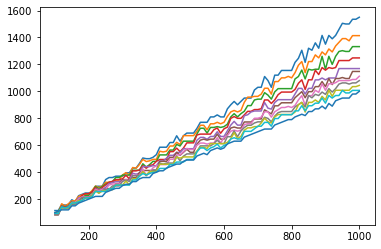

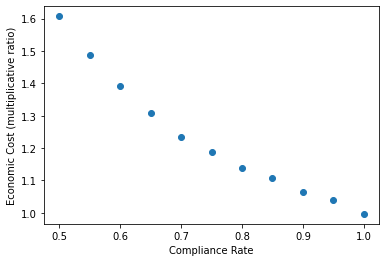

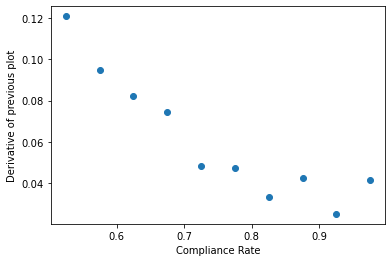

In [22]:
#montgomery, t7.json
economic_plot("run_B9PKb")

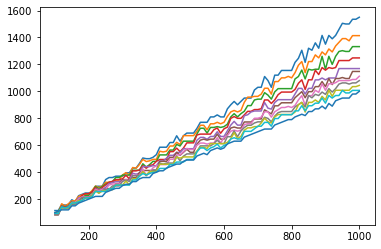

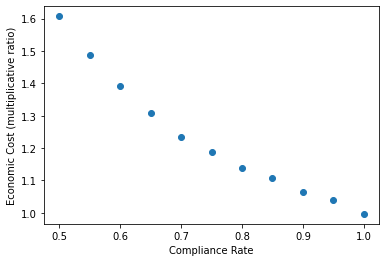

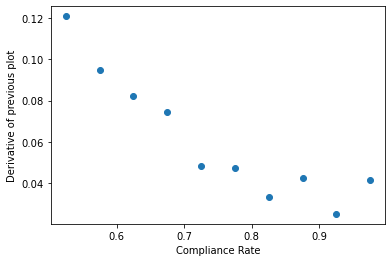

In [23]:
#montgomery, t8.json
economic_plot("run_HHunU")

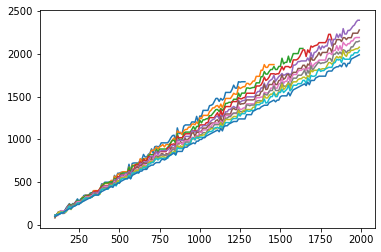

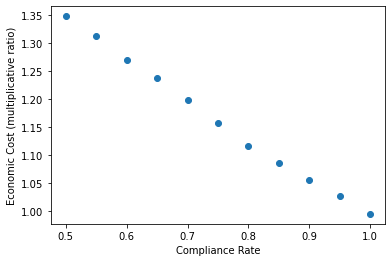

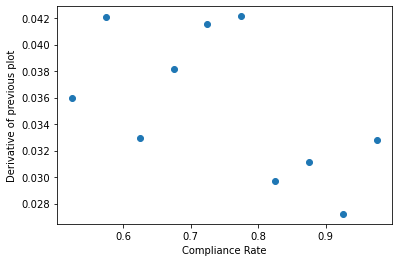

In [10]:
#charlottesville, a5.json
economic_plot("run_HqNSh", 2000)

In [ ]:
#charlottesville, a6.json
economic_plot("run_hArmg")

In [9]:
def economic_plot(folder: str, maximum:int = 1000):
    df = pd.read_csv("../output/" + folder + "/results.csv")
    df = df.sort_values(by='compliance_rate')
    df1 = df[df.compliance_rate==1]

    x=[]
    y=[[] for _ in df.compliance_rate.unique()]
    df_arr = [df[df.compliance_rate==i].reset_index(drop=True) for i in df.compliance_rate.unique()]

    for B in range(100,maximum,10):

        val = df1[df1.budget==B]['infected_count_real'].mean()
        x.append(B)

        for i,rate in enumerate(df.compliance_rate.unique()):

            budgets = df_arr[i].budget.unique()
            budgets.sort()

            for b in budgets:

                if df_arr[i][df_arr[i].budget==b]['infected_count_real'].mean() <= val:
                    y[i].append(b*rate)
                    break
                    
    m=[]
    n=[]

    for i,yi in enumerate(y):    
        a,b = np.polyfit(x=x[:len(yi)],y=yi,deg=1)
        m.append(df.compliance_rate.unique()[i])
        n.append(a)
        sns.lineplot(x=x[:len(yi)],y=yi)
    plt.show()
    
    plt.scatter(x=m,y=n)    
    plt.xlabel("Compliance Rate")
    plt.ylabel("Economic Cost (multiplicative ratio)")
    plt.show()
    
    n_prime=[]
    m_prime=[]

    for (i,v) in enumerate(n):
        if(i!=0):
            n_prime.append(n[i-1]-n[i])
            m_prime.append(.5*m[i]+.5*m[i-1])
            
    plt.scatter(x=m_prime,y=n_prime)    
    plt.xlabel("Compliance Rate")
    plt.ylabel("Derivative of previous plot")
    plt.show()

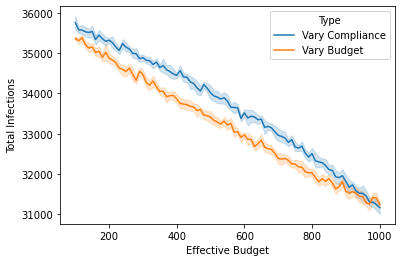

In [17]:
df = pd.read_csv("../output/run_bh8Gt/results.csv")
df1 = pd.read_csv("../output/run_5GQVw/results.csv")
df['Type'] = 'Vary Compliance'
df1['Type'] = 'Vary Budget'

df = pd.concat([df,df1])

df['effective_budget'] = df['compliance_rate'] * df['budget']

sns.lineplot(data=df, x='effective_budget',y='infected_count_known',hue='Type')
plt.ylabel("Total Infections")
plt.xlabel("Effective Budget")
plt.show()

In [3]:
G = load_graph("montgomery")

In [4]:
I = set()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "t7.json", 'r') as infile:
    j = json.load(infile)
    (S, infected_queue, R) = (j["S"], j["I_Queue"], j["R"])

    # Make infected_queue a list of sets
    infected_queue = [set(s) for s in infected_queue]
    I = I.union(*infected_queue)
    I = list(I)

In [ ]:
#this is how the code is used
for i in [10,100,1000,2000,5000,10000]:
    a = time.time()
    state = SimulationState(G, (S,I,R), (S,I,R), 1000, .078,1,1,1,1)
    agent = SAA_Diffusion

    while len(state.SIR_known.SIR[1]) != 0:
        #print(len(state.SIR_known.SIR[1]))
        to_quarantine = agent(state,num_samples=i)
        state.step(to_quarantine)

        #print(state.SIR_known.V1 == state.SIR_real.V1)
        #print("S :" + str(len(state.SIR_known.SIR.S)) + " " + str(len(state.SIR_real.SIR.S)))
        #print("I :" + str(len(state.SIR_known.SIR.I)) + " " + str(len(state.SIR_real.SIR.I)))
        #print("R :" + str(len(state.SIR_known.SIR.R)) + " " + str(len(state.SIR_real.SIR.R)))

        #print()

        #print(len(set(state.SIR_known.SIR.R).difference(set(state.SIR_real.SIR.R))))
        #print(len(set(state.SIR_real.SIR.R).difference(set(state.SIR_known.SIR.R))))
    print(time.time()-a)
    #print(len(state.SIR_known.SIR[1]))
    #print()
    print(len(state.SIR_known.SIR[2])/75457)
    #print(len(state.SIR_known.SIR[0]),len(state.SIR_real.SIR[0]))

In [2]:
print([i/100 for i in range(50,101,5)])

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


In [ ]:
problem = MinExposedSAADiffusion(state.SIR_known)

In [28]:
len(state.SIR_real.SIR[0] + state.SIR_real.SIR[1] + state.SIR_real.SIR[2])

75457

In [179]:
agents = [NoIntervention, Random, Degree, DepRound, DegGreedy]

In [180]:
for agent in agents:
    state = SimulationState(G, (S,I,R), (S,I,R), 2000, .078,1,1, 1,1)

    while len(state.SIR_known.SIR[1]) != 0:
        to_quarantine = agent(state)
        state.step(to_quarantine)

    print(agent.__name__ + " " + str(len(state.SIR_known.SIR[2])))


NoIntervention 36169
Random 30674
Degree 24299
DegGreedy 21525
DepRound 23785
